In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df=pd.read_csv("RMS_Crime_Incidents.csv")
df.head()

,CrimeType,Location,Hour,Day,Severity
0,Theft,Area1,10,Monday,2
1,Assault,Area2,22,Friday,4
2,Robbery,Area1,18,Saturday,3
3,Theft,Area3,14,Wednesday,2
4,Assault,Area2,21,Sunday,5


In [3]:
df.shape

(5, 5)

In [4]:
df.columns

Index(['CrimeType', 'Location', 'Hour', 'Day', 'Severity'], dtype='str')

In [5]:
df.describe()

,Hour,Severity
count,5.0,5.00000
mean,17.0,3.20000
std,5.0,1.30384
min,10.0,2.00000
25%,14.0,2.00000
50%,18.0,3.00000
75%,21.0,4.00000
max,22.0,5.00000


In [ ]:
df.info()

In [ ]:
#Paper ke mutabiq humein sirf yeh columns chahiye the kyunke yeh features use hote hain crime type aur location predict karne ke liye.
df = df[['incident_day_of_week', 'incident_hour_of_day', 'zip_code', 'offense_category']]

# Rename columns just for our understanding according to paper bcz these column names are mentioned in the paper
df = df.rename(columns={
    'incident_day_of_week': 'day_of_week',
    'incident_hour_of_day': 'hour',
    'offense_category': 'crime_category'
})

In [ ]:
# Check for missing values and drop them
df = df.dropna()
print("Missing values after drop:\n", df.isnull().sum())

In [ ]:
# Count incidents per crime category
category_counts = df['crime_category'].value_counts()
category_counts

In [ ]:
#Dataset mein originally ~38 crime categories thi, lekin paper ke according humne sirf un categories ko rakha jin ke incidents ≥600 the, taake data balanced ho.
selected_categories = category_counts[category_counts >= 600].index
df_filtered = df[df['crime_category'].isin(selected_categories)]
# Verify the number of categories
print(f"Number of crime categories after filtering: {len(selected_categories)}")
print("Selected categories:\n", selected_categories)

print(f"Unique zip codes: {len(df_filtered['zip_code'].unique())}")
print(f"Unique days of week: {len(df_filtered['day_of_week'].unique())}")
print(f"HourHour is numerical: 1 feature")

In [ ]:
# Humne dataset ko do parts mein divide kiya: training set aur validation set.
# Training set ko balanced banaya:
# Har crime category ke liye:
# Agar total incidents ≥700 the, to 350 samples liye.
# Agar 600 ≤ incidents < 700 the, to total / 2 samples liye.
# Badi categories ke liye thodi extra samples add kiye (max 370 tak).
# Baaki sab samples validation set mein gaye.
train_samples = []
for category in selected_categories:
    category_df = df_filtered[df_filtered['crime_category'] == category]
    total = len(category_df)
    if total >= 700:
        n_train = 350
    else:
        n_train = total // 2
    # Add proportional extra samples for large clusters (up to 370)
    if total > 700:
        n_train = min(370, n_train + int((total - 700) * 0.1))
    train_sample = category_df.sample(n=n_train, random_state=42)
    train_samples.append(train_sample)

# Combine training samples
train_df = pd.concat(train_samples)
# Validation set
validation_df = df_filtered[~df_filtered.index.isin(train_df.index)]

# Verify sizes
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(validation_df)}")
# Paper ke according training set balanced hona chahiye taake har category ka equal representation ho.
# Validation set bada tha kyunke woh real-world testing ke liye use hota hai.

In [ ]:
#prepare dataset for our two models as menioned in paper
#1. Crime Type Prediction
#2. Crime Location Prediction

# Categorical variables (zip_code, day_of_week, crime_category) ko one-hot encoding se convert kiya (0s aur 1s ke matrices) or hour ko numerical he rakha
# Reason: Paper ke mutabiq, categorical data ko one-hot encode karna tha kyunke neural networks raw categories nahi samajhte.
zip_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
day_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
category_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
# Fit encoders
zip_encoder.fit(df_filtered[['zip_code']])
day_encoder.fit(df_filtered[['day_of_week']])
category_encoder.fit(df_filtered[['crime_category']])

In [ ]:
# Prepare inputs and outputs for crime type prediction
X_train_crime = np.hstack([
    zip_encoder.transform(train_df[['zip_code']]),
    day_encoder.transform(train_df[['day_of_week']]),
    train_df['hour'].values.reshape(-1, 1)
])
y_train_crime = np.argmax(category_encoder.transform(train_df[['crime_category']]), axis=1)
X_val_crime = np.hstack([
    zip_encoder.transform(validation_df[['zip_code']]),
    day_encoder.transform(validation_df[['day_of_week']]),
    validation_df['hour'].values.reshape(-1, 1)
])
y_val_crime = np.argmax(category_encoder.transform(validation_df[['crime_category']]), axis=1)

In [ ]:
# Prepare inputs and outputs for location prediction
X_train_loc = np.hstack([
    category_encoder.transform(train_df[['crime_category']]),
    day_encoder.transform(train_df[['day_of_week']]),
    train_df['hour'].values.reshape(-1, 1)
])
y_train_loc = np.argmax(zip_encoder.transform(train_df[['zip_code']]), axis=1)
X_val_loc = np.hstack([
    category_encoder.transform(validation_df[['crime_category']]),
    day_encoder.transform(validation_df[['day_of_week']]),
    validation_df['hour'].values.reshape(-1, 1)
])
y_val_loc = np.argmax(zip_encoder.transform(validation_df[['zip_code']]), axis=1)

In [ ]:
# Data ko PyTorch tensors mein convert kiya taake model training ke liye ready ho.
X_train_crime = torch.tensor(X_train_crime, dtype=torch.float32)
y_train_crime = torch.tensor(y_train_crime, dtype=torch.long)
X_val_crime = torch.tensor(X_val_crime, dtype=torch.float32)
y_val_crime = torch.tensor(y_val_crime, dtype=torch.long)

X_train_loc = torch.tensor(X_train_loc, dtype=torch.float32)
y_train_loc = torch.tensor(y_train_loc, dtype=torch.long)
X_val_loc = torch.tensor(X_val_loc, dtype=torch.float32)
y_val_loc = torch.tensor(y_val_loc, dtype=torch.long)

In [ ]:
# Verify shapes
print("Crime Type - X_train shape:", X_train_crime.shape, "y_train shape:", y_train_crime.shape)
print("Location - X_train shape:", X_train_loc.shape, "y_train shape:", y_train_loc.shape)

In [ ]:
#Humne do models banaye, dono Multi-Layer Perceptrons (MLPs), jo paper ke according hain. Training ke liye PyTorch use kiya aur Adam optimizer (modern backpropagation) ke sath early stopping add kiya.
# Define the MLP model for Crime Type Prediction
class CrimeTypeMLP(nn.Module):
    def __init__(self):
        super(CrimeTypeMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(38, 12),
            nn.Sigmoid(),
            nn.Linear(12, 4),
            nn.Sigmoid(),
            nn.Linear(4, 25)
        )
    def forward(self, x):
        return self.layers(x)

In [ ]:
# Create data loaders
train_dataset_crime = TensorDataset(X_train_crime, y_train_crime)
val_dataset_crime = TensorDataset(X_val_crime, y_val_crime)
train_loader_crime = DataLoader(train_dataset_crime, batch_size=32, shuffle=True)
val_loader_crime = DataLoader(val_dataset_crime, batch_size=32)

In [ ]:
# Initialize model, loss, and optimizer
model_crime = CrimeTypeMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_crime.parameters())

In [ ]:
# Training loop with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct / total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.1f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'crime_type_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

# Train the model
train_model(model_crime, train_loader_crime, val_loader_crime, criterion, optimizer)

In [ ]:
# Load best model and evaluate
model_crime.load_state_dict(torch.load('crime_type_model.pt'))
model_crime.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader_crime:
        outputs = model_crime(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
accuracy = correct / total
print(f"Crime Type Prediction Accuracy: {accuracy * 100:.1f}%")

In [ ]:
#Unique crime categories: 25
# Unique days of week: 7
# Hour is numerical: 1 feature
# Total input features for Location Model: 25+7+1=33
# Unique zip codes (output): 30

# Define the MLP model Crime Location Prediction
class LocationMLP(nn.Module):
    def __init__(self):
        super(LocationMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(33, 27),
            nn.Sigmoid(),
            nn.Linear(27, 6),
            nn.Sigmoid(),
            nn.Linear(6, 30)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
# Create data loaders
train_dataset_loc = TensorDataset(X_train_loc, y_train_loc)
val_dataset_loc = TensorDataset(X_val_loc, y_val_loc)
train_loader_loc = DataLoader(train_dataset_loc, batch_size=32, shuffle=True)
val_loader_loc = DataLoader(val_dataset_loc, batch_size=32)

In [ ]:
# Initialize model, loss, and optimizer
model_loc = LocationMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_loc.parameters())

In [ ]:
# Train the model
train_model(model_loc, train_loader_loc, val_loader_loc, criterion, optimizer)

In [ ]:
# Load best model and evaluate
model_loc.load_state_dict(torch.load('location_model.pt'))
model_loc.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in val_loader_loc:
        outputs = model_loc(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
accuracy = correct / total
print(f"Location Prediction Exact Accuracy: {accuracy * 100:.1f}%")

In [ ]:
# Predict zip codes
model_loc.eval()
y_pred_loc = []
y_true_loc = []
with torch.no_grad():
    for X_batch, y_batch in val_loader_loc:
        outputs = model_loc(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred_loc.extend(predicted.numpy())
        y_true_loc.extend(y_batch.numpy())

y_pred_loc = np.array(y_pred_loc)
y_true_loc = np.array(y_true_loc)

# Exact accuracy
exact_matches = np.sum(y_pred_loc == y_true_loc)
exact_accuracy = exact_matches / len(y_true_loc)
print(f"Exact Accuracy: {exact_accuracy * 100:.1f}%")

In [ ]:
# Save models
torch.save(model_crime.state_dict(), 'crime_type_model.pt')
torch.save(model_loc.state_dict(), 'location_model.pt')

In [3]:
print(df.info())
print(df.describe())


<class 'pandas.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   CrimeType  5 non-null      str  
 1   Location   5 non-null      str  
 2   Hour       5 non-null      int64
 3   Day        5 non-null      str  
 4   Severity   5 non-null      int64
dtypes: int64(2), str(3)
memory usage: 332.0 bytes
None
       Hour  Severity
count   5.0   5.00000
mean   17.0   3.20000
std     5.0   1.30384
min    10.0   2.00000
25%    14.0   2.00000
50%    18.0   3.00000
75%    21.0   4.00000
max    22.0   5.00000


In [2]:
import pandas as pd
df = pd.read_csv("RMS_Crime_Incidents.csv")
df.head()


,CrimeType,Location,Hour,Day,Severity
0,Theft,Area1,10,Monday,2
1,Assault,Area2,22,Friday,4
2,Robbery,Area1,18,Saturday,3
3,Theft,Area3,14,Wednesday,2
4,Assault,Area2,21,Sunday,5


In [4]:
df['CrimeType'].value_counts()


CrimeType
Theft      2
Assault    2
Robbery    1
Name: count, dtype: int64

Matplotlib is building the font cache; this may take a moment.


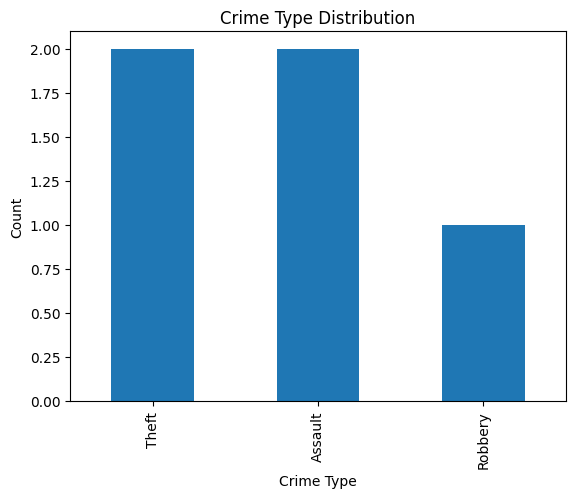

In [5]:
import matplotlib.pyplot as plt

df['CrimeType'].value_counts().plot(kind='bar')
plt.title("Crime Type Distribution")
plt.xlabel("Crime Type")
plt.ylabel("Count")
plt.show()


In [ ]:
df['Risk_Level'] = df['Severity'].apply(lambda x: "High Risk" if x >= 4 else "Low Risk")
df[['CrimeType', 'Location', 'Risk_Level']]
